In [ ]:
# SISTEM REKOMENDASI HANDPHONE
# Dengan Metode User Based Collaborative Filtering Berbasis Algoritma SVD (Singular Value Decomposition)

In [ ]:
# Import library
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
# Import data set
datasetReviews = pd.read_csv('20191226-reviews.csv')
datasetItems = pd.read_csv('20191226-items.csv')
datasetItems = datasetItems.dropna(axis = 1)
dataset = pd.merge(datasetReviews,datasetItems, on='asin')
dataset.to_csv("merged_output", index=False)


In [ ]:
datasetItems.head(1)

,asin,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0


In [ ]:
datasetReviews.head(1)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0


In [ ]:
dataset.head(1)

,asin,name,rating_x,date,verified,title_x,body,helpfulVotes,title_y,url,image,rating_y,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0


In [ ]:
print('Jumlah nilai yang kosong sebelum di hilangkan data null nya \n', dataset.isnull().sum())

Jumlah nilai yang kosong sebelum di hilangkan data null nya 
 asin                 0
name                 2
rating_x             0
date                 0
verified             0
title_x             14
body                21
helpfulVotes     40771
title_y              0
url                  0
image                0
rating_y             0
reviewUrl            0
totalReviews         0
price                0
originalPrice        0
dtype: int64


In [ ]:
# Drop kolom yang tidak terpakai
dataset = dataset.drop(['date', 'verified','title_x','body','helpfulVotes','url','rating_y','reviewUrl','totalReviews','image','price','originalPrice' ], axis = 1) 

In [ ]:
# Mengecek tipe datanya
dataset.dtypes

asin        object
name        object
rating_x     int64
title_y     object
dtype: object

In [ ]:
# Mengecek null
print('Jumlah nilai yang kosong\n', dataset.isnull().sum())

Jumlah nilai yang kosong
 asin        0
name        2
rating_x    0
title_y     0
dtype: int64


In [ ]:
# Menghapus baris yang data namanya kosong
dataset.dropna(inplace=True)
dataset.isnull().sum()

asin        0
name        0
rating_x    0
title_y     0
dtype: int64

In [ ]:
# Melihat beberapa baris data dari dataset
dataset.tail()

,asin,name,rating_x,title_y
67981,B081H6STQQ,jande,5,Sony Xperia 1 Unlocked Smartphone and WH1000XM...
67982,B081H6STQQ,2cool4u,5,Sony Xperia 1 Unlocked Smartphone and WH1000XM...
67983,B081H6STQQ,simon,5,Sony Xperia 1 Unlocked Smartphone and WH1000XM...
67984,B081TJFVCJ,Tobiasz Jedrysiak,5,"Apple iPhone X, 64GB, Gray - Fully Unlocked (R..."
67985,B0825BB7SG,Owen Gonzalez,5,Straight Talk Samsung Galaxy A10e Smartphone 5...


In [ ]:
# Mengecek jumlah baris dan kolomnya
rows, columns = dataset.shape
print("Jumlah baris: ", rows) 
print("Jumlah kolom: ", columns) 

Jumlah baris:  67984
Jumlah kolom:  4


In [ ]:
# Data ringkasan statistik variabel rating
dataset[['rating_x']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating_x,67984.0,3.807911,1.582919,1.0,3.0,5.0,5.0,5.0


In [ ]:
# Mencari nilai min max dari rating

def find_min_max_rating():
    print('Rating minimumnya adalah: %d' %(dataset['rating_x'].min()))
    print('Rating maksimumnya adalah: %d' %(dataset['rating_x'].max()))
    
find_min_max_rating() 

Rating minimumnya adalah: 1
Rating maksimumnya adalah: 5


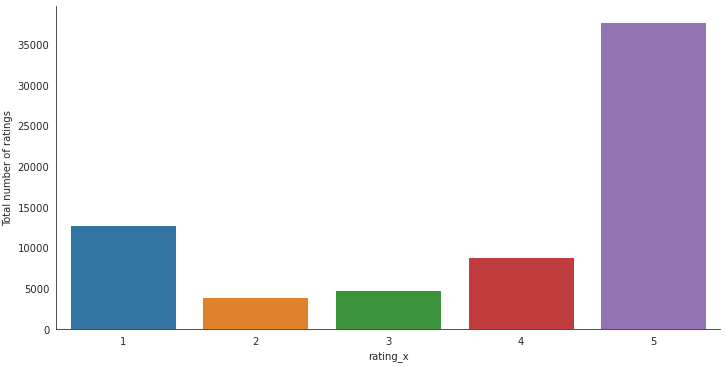

In [ ]:
# Diagram distribusi rating
with sns.axes_style('white'):
    g = sns.factorplot("rating_x", data=dataset, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")


In [ ]:
# Melihat jumlah item dan user yang unique
print('Jumlah unique USERS di dataset = ', dataset['name'].nunique())
print('Jumlah unique ITEMS di dataset = ', dataset['asin'].nunique())
print('Jumlah unique TITTLE di dataset = ', dataset['title_y'].nunique())

Jumlah unique USERS di dataset =  47323
Jumlah unique ITEMS di dataset =  720
Jumlah unique TITTLE di dataset =  718


In [ ]:
#Top 10 users berdasar rating
most_rated = dataset.groupby('name').size().sort_values(ascending=False)[:10]
most_rated

name
Amazon Customer      6507
Kindle Customer       360
Chris                  89
John                   87
Michael                77
Mike                   73
David                  70
Alex                   64
Cliente de Amazon      62
James                  58
dtype: int64

In [ ]:
# Persiapan model data sesuai persyaratan jumlah peringkat minimum agar rmse kecil
counts = dataset['name'].value_counts()
dataset_final = dataset[dataset['name'].isin(counts[counts >= 50].index)]

In [ ]:
dataset_final.head()

,asin,name,rating_x,title_y
9,B0000SX2UC,Amazon Customer,3,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...
27,B000SKTZ0S,Amazon Customer,1,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...
45,B001AO4OUC,Amazon Customer,5,Motorola i335 Cell Phone Boost Mobile
64,B001DCJAJG,Kindle Customer,4,Motorola V365 no contract cellular phone AT&T
109,B002AS9WEA,Amazon Customer,2,Samsung a167 Prepaid GoPhone (AT&T)


In [ ]:
print('Jumlah user yang memberi rating di >=50 items =', len(dataset_final))
print('Jumlah unique USERS di final data = ', dataset_final['name'].nunique())
print('Jumlah unique ITEMS di final data = ', dataset_final['asin'].nunique())
print('Jumlah unique TITTLE di final data = ', dataset_final['title_y'].nunique())

Jumlah user yang memberi rating di >=50 items = 7503
Jumlah unique USERS di final data =  11
Jumlah unique ITEMS di final data =  546
Jumlah unique TITTLE di final data =  544


In [ ]:
# Menghitung density rating matrix

final_ratings_matrix = pd.pivot_table(dataset_final,index=['name'], columns = 'title_y', values = "rating_x") 
final_ratings_matrix.fillna(0,inplace=True)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (11, 544)
given_num_of_ratings =  1247
possible_num_of_ratings =  5984
density: 20.84%


In [ ]:
# Split data training dan testing dengan ratio 70:30
train_data, test_data = train_test_split(dataset_final, test_size = 0.3, random_state=0)

print(train_data.head(5))

             asin             name  rating_x  \
35438  B071JP8XDJ  Amazon Customer         5   
29369  B01N9XOXCK             Mike         3   
67757  B07YZLRS3Z  Amazon Customer         4   
22682  B01DUPOOMG  Amazon Customer         3   
15999  B00WF988BW  Amazon Customer         5   

                                                 title_y  
35438  Sony Xperia XA1 Ultra G3223 32GB Unlocked GSM ...  
29369  Samsung Galaxy S7 Edge G935V 32GB Gold - Veriz...  
67757  Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3" LTE 4...  
22682  Samsung Galaxy S6 G920P 32GB Black Boost Mobil...  
15999  Samsung Convoy 3 SCH-U680 Rugged 3G Cell Phone...  


In [ ]:
def shape():
    print("Test data shape: ", test_data.shape)
    print("Train data shape: ", train_data.shape)
shape()

Test data shape:  (2251, 4)
Train data shape:  (5252, 4)


In [ ]:
# Membuat Collaborative Filtering model

dataframe_CF = pd.concat([train_data, test_data]).reset_index()
dataframe_CF.tail()

,index,asin,name,rating_x,title_y
7498,34737,B06Y3HCFZT,Amazon Customer,5,"Samsung Galaxy S8+, 6.2"" 64GB (Verizon Wireles..."
7499,18507,B014GCG150,Amazon Customer,4,Samsung Galaxy J5 SM-J500H/DS GSM Factory Unlo...
7500,12647,B00MWI4KKE,Amazon Customer,4,Motorola Moto X (2nd generation) XT1097 GSM Un...
7501,13714,B00O15MWOM,Amazon Customer,4,Nokia Lumia 530 White - No Contract (T-Mobile)
7502,17843,B013XAPUW6,Chris,4,"Samsung Galaxy Note 5, Black 64GB (Verizon Wi..."


In [ ]:
# User-based Collaborative Filtering
# Membuat matrix dengan perbaris user dan kolom per item 
pivot_df = pd.pivot_table(dataframe_CF,index=['name'], columns = 'title_y', values = "rating_x")
pivot_df.fillna(0,inplace=True)
print(pivot_df.shape)
pivot_df.head()

(11, 544)


title_y,ASUS ZenFone 5Z (ZS620KL-S845-6G64G) - 6.2” FHD+ 2160x1080 display - 6GB RAM - 64GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Midnight Blue,ASUS ZenFone Max Plus ZB570TL-MT67-3G32G-BL - 5.7” 1920x1080-3GB RAM - 32GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Silver,"Apple MGLW2LL/A iPad Air 2 9.7-Inch Retina Display, 16GB, Wi-Fi (Silver) (Renewed)","Apple iPad Air MF529LL/A (32GB, Wi-Fi + at&T, White with Silver) (Renewed)","Apple iPad mini 4 (32GB, Wi-Fi + Cellular, Space Gray) (Renewed)","Apple iPhone 11 Pro, 64GB, Fully Unlocked - Space Gray (Renewed)","Apple iPhone 6S Plus, 16GB, Silver - For AT&T / T-Mobile (Renewed)","Apple iPhone 6S Plus, 64GB, Rose Gold - For AT&T / T-Mobile (Renewed)","Apple iPhone 6S Plus, 64GB, Silver - Fully Unlocked (Renewed)","Apple iPhone 6S, 128GB, Rose Gold - For AT&T / T-Mobile (Renewed)",...,"Xiaomi Redmi Note 7 (64GB, 4GB) 6.3"" Display, 48MP + 5MP AI Dual Rear Camera, Global 4G LTE Dual SIM GSM Factory Unlocked (International Model w/ 64GB MicroSD Bundle) (Black)","Xiaomi Redmi Note 7 128GB + 4GB RAM 6.3"" FHD+ LTE Factory Unlocked 48MP GSM Smartphone (Global Version, No Warranty) (Neptune Blue)","Xiaomi Redmi Note 7 128GB + 4GB RAM 6.3"" FHD+ LTE Factory Unlocked 48MP GSM Smartphone (Global Version, No Warranty) (Space Black)","Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Black - Unlocked Global Version","Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Blue - Unlocked Global Version, No Warranty","Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3"" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Moonlight White)","Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3"" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Space Black)","Xiaomi Redmi Note 8 Pro (64GB, 6GB) 6.53"", 64MP Quad Camera, Helio G90T Gaming Processor, Dual SIM GSM Unlocked - US & Global 4G LTE International Version (Pearl White, 64 GB)","Xiaomi Redmi Note 8 Pro 128GB, 6GB RAM 6.53"" LTE GSM 64MP Smartphone - Global Model (Mineral Grey)","Xiaomi Redmi Note 8 Pro 64GB, 6GB RAM 6.53"" LTE GSM 64MP Factory Unlocked Smartphone - Global Model (Mineral Grey)"
name,,,,,,,,,,,,,,,,,,,,,
Alex,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,5.0,0.000000,5.0,3.000000,0.000000,0.00,0.00,0.00,0.000000,0.00
Amazon Customer,4.8,4.285714,4.461538,2.5,5.0,1.0,3.727273,3.0,4.0,3.0,...,0.0,3.833333,3.2,4.139535,4.346154,3.75,3.75,4.75,4.333333,4.75
Chris,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,5.0,4.000000,4.000000,0.00,0.00,0.00,0.000000,0.00
Cliente de Amazon,5.0,4.000000,0.000000,0.0,0.0,0.0,3.666667,0.0,0.0,0.0,...,0.0,0.000000,0.0,5.000000,0.000000,5.00,5.00,5.00,0.000000,5.00
Daniel,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,1.0,0.000000,5.000000,0.00,0.00,0.00,0.000000,0.00


In [ ]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

title_y,ASUS ZenFone 5Z (ZS620KL-S845-6G64G) - 6.2” FHD+ 2160x1080 display - 6GB RAM - 64GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Midnight Blue,ASUS ZenFone Max Plus ZB570TL-MT67-3G32G-BL - 5.7” 1920x1080-3GB RAM - 32GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Silver,"Apple MGLW2LL/A iPad Air 2 9.7-Inch Retina Display, 16GB, Wi-Fi (Silver) (Renewed)","Apple iPad Air MF529LL/A (32GB, Wi-Fi + at&T, White with Silver) (Renewed)","Apple iPad mini 4 (32GB, Wi-Fi + Cellular, Space Gray) (Renewed)","Apple iPhone 11 Pro, 64GB, Fully Unlocked - Space Gray (Renewed)","Apple iPhone 6S Plus, 16GB, Silver - For AT&T / T-Mobile (Renewed)","Apple iPhone 6S Plus, 64GB, Rose Gold - For AT&T / T-Mobile (Renewed)","Apple iPhone 6S Plus, 64GB, Silver - Fully Unlocked (Renewed)","Apple iPhone 6S, 128GB, Rose Gold - For AT&T / T-Mobile (Renewed)",...,"Xiaomi Redmi Note 7 128GB + 4GB RAM 6.3"" FHD+ LTE Factory Unlocked 48MP GSM Smartphone (Global Version, No Warranty) (Neptune Blue)","Xiaomi Redmi Note 7 128GB + 4GB RAM 6.3"" FHD+ LTE Factory Unlocked 48MP GSM Smartphone (Global Version, No Warranty) (Space Black)","Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Black - Unlocked Global Version","Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Blue - Unlocked Global Version, No Warranty","Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3"" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Moonlight White)","Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3"" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Space Black)","Xiaomi Redmi Note 8 Pro (64GB, 6GB) 6.53"", 64MP Quad Camera, Helio G90T Gaming Processor, Dual SIM GSM Unlocked - US & Global 4G LTE International Version (Pearl White, 64 GB)","Xiaomi Redmi Note 8 Pro 128GB, 6GB RAM 6.53"" LTE GSM 64MP Smartphone - Global Model (Mineral Grey)","Xiaomi Redmi Note 8 Pro 64GB, 6GB RAM 6.53"" LTE GSM 64MP Factory Unlocked Smartphone - Global Model (Mineral Grey)",user_index
name,,,,,,,,,,,,,,,,,,,,,
Alex,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,5.0,3.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0
Amazon Customer,4.8,4.285714,4.461538,2.5,5.0,1.0,3.727273,3.0,4.0,3.0,...,3.833333,3.2,4.139535,4.346154,3.75,3.75,4.75,4.333333,4.75,1
Chris,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,5.0,4.000000,4.000000,0.00,0.00,0.00,0.000000,0.00,2
Cliente de Amazon,5.0,4.000000,0.000000,0.0,0.0,0.0,3.666667,0.0,0.0,0.0,...,0.000000,0.0,5.000000,0.000000,5.00,5.00,5.00,0.000000,5.00,3
Daniel,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,1.0,0.000000,5.000000,0.00,0.00,0.00,0.000000,0.00,4


In [ ]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual rating yang diberikan oleh user
pivot_df.head()

title_y,ASUS ZenFone 5Z (ZS620KL-S845-6G64G) - 6.2” FHD+ 2160x1080 display - 6GB RAM - 64GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Midnight Blue,ASUS ZenFone Max Plus ZB570TL-MT67-3G32G-BL - 5.7” 1920x1080-3GB RAM - 32GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Silver,"Apple MGLW2LL/A iPad Air 2 9.7-Inch Retina Display, 16GB, Wi-Fi (Silver) (Renewed)","Apple iPad Air MF529LL/A (32GB, Wi-Fi + at&T, White with Silver) (Renewed)","Apple iPad mini 4 (32GB, Wi-Fi + Cellular, Space Gray) (Renewed)","Apple iPhone 11 Pro, 64GB, Fully Unlocked - Space Gray (Renewed)","Apple iPhone 6S Plus, 16GB, Silver - For AT&T / T-Mobile (Renewed)","Apple iPhone 6S Plus, 64GB, Rose Gold - For AT&T / T-Mobile (Renewed)","Apple iPhone 6S Plus, 64GB, Silver - Fully Unlocked (Renewed)","Apple iPhone 6S, 128GB, Rose Gold - For AT&T / T-Mobile (Renewed)",...,"Xiaomi Redmi Note 7 (64GB, 4GB) 6.3"" Display, 48MP + 5MP AI Dual Rear Camera, Global 4G LTE Dual SIM GSM Factory Unlocked (International Model w/ 64GB MicroSD Bundle) (Black)","Xiaomi Redmi Note 7 128GB + 4GB RAM 6.3"" FHD+ LTE Factory Unlocked 48MP GSM Smartphone (Global Version, No Warranty) (Neptune Blue)","Xiaomi Redmi Note 7 128GB + 4GB RAM 6.3"" FHD+ LTE Factory Unlocked 48MP GSM Smartphone (Global Version, No Warranty) (Space Black)","Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Black - Unlocked Global Version","Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Blue - Unlocked Global Version, No Warranty","Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3"" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Moonlight White)","Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3"" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Space Black)","Xiaomi Redmi Note 8 Pro (64GB, 6GB) 6.53"", 64MP Quad Camera, Helio G90T Gaming Processor, Dual SIM GSM Unlocked - US & Global 4G LTE International Version (Pearl White, 64 GB)","Xiaomi Redmi Note 8 Pro 128GB, 6GB RAM 6.53"" LTE GSM 64MP Smartphone - Global Model (Mineral Grey)","Xiaomi Redmi Note 8 Pro 64GB, 6GB RAM 6.53"" LTE GSM 64MP Factory Unlocked Smartphone - Global Model (Mineral Grey)"
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,5.0,0.000000,5.0,3.000000,0.000000,0.00,0.00,0.00,0.000000,0.00
1,4.8,4.285714,4.461538,2.5,5.0,1.0,3.727273,3.0,4.0,3.0,...,0.0,3.833333,3.2,4.139535,4.346154,3.75,3.75,4.75,4.333333,4.75
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,5.0,4.000000,4.000000,0.00,0.00,0.00,0.000000,0.00
3,5.0,4.000000,0.000000,0.0,0.0,0.0,3.666667,0.0,0.0,0.0,...,0.0,0.000000,0.0,5.000000,0.000000,5.00,5.00,5.00,0.000000,5.00
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,1.0,0.000000,5.000000,0.00,0.00,0.00,0.000000,0.00


In [ ]:
# Algoritma SVD (Singular Value Decomposition)
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(pivot_df, k = 5)
# Membuat diagonal array di SVD
sigma = np.diag(sigma)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

title_y,ASUS ZenFone 5Z (ZS620KL-S845-6G64G) - 6.2” FHD+ 2160x1080 display - 6GB RAM - 64GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Midnight Blue,ASUS ZenFone Max Plus ZB570TL-MT67-3G32G-BL - 5.7” 1920x1080-3GB RAM - 32GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Silver,"Apple MGLW2LL/A iPad Air 2 9.7-Inch Retina Display, 16GB, Wi-Fi (Silver) (Renewed)","Apple iPad Air MF529LL/A (32GB, Wi-Fi + at&T, White with Silver) (Renewed)","Apple iPad mini 4 (32GB, Wi-Fi + Cellular, Space Gray) (Renewed)","Apple iPhone 11 Pro, 64GB, Fully Unlocked - Space Gray (Renewed)","Apple iPhone 6S Plus, 16GB, Silver - For AT&T / T-Mobile (Renewed)","Apple iPhone 6S Plus, 64GB, Rose Gold - For AT&T / T-Mobile (Renewed)","Apple iPhone 6S Plus, 64GB, Silver - Fully Unlocked (Renewed)","Apple iPhone 6S, 128GB, Rose Gold - For AT&T / T-Mobile (Renewed)",...,"Xiaomi Redmi Note 7 (64GB, 4GB) 6.3"" Display, 48MP + 5MP AI Dual Rear Camera, Global 4G LTE Dual SIM GSM Factory Unlocked (International Model w/ 64GB MicroSD Bundle) (Black)","Xiaomi Redmi Note 7 128GB + 4GB RAM 6.3"" FHD+ LTE Factory Unlocked 48MP GSM Smartphone (Global Version, No Warranty) (Neptune Blue)","Xiaomi Redmi Note 7 128GB + 4GB RAM 6.3"" FHD+ LTE Factory Unlocked 48MP GSM Smartphone (Global Version, No Warranty) (Space Black)","Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Black - Unlocked Global Version","Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Blue - Unlocked Global Version, No Warranty","Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3"" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Moonlight White)","Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3"" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Space Black)","Xiaomi Redmi Note 8 Pro (64GB, 6GB) 6.53"", 64MP Quad Camera, Helio G90T Gaming Processor, Dual SIM GSM Unlocked - US & Global 4G LTE International Version (Pearl White, 64 GB)","Xiaomi Redmi Note 8 Pro 128GB, 6GB RAM 6.53"" LTE GSM 64MP Smartphone - Global Model (Mineral Grey)","Xiaomi Redmi Note 8 Pro 64GB, 6GB RAM 6.53"" LTE GSM 64MP Factory Unlocked Smartphone - Global Model (Mineral Grey)"
0,0.566869,0.524041,1.094380,-0.039902,-0.079803,-0.015961,0.754850,-0.047882,-0.063843,-0.047882,...,0.644624,-0.061183,1.865850,1.410722,1.634230,0.583628,0.583628,0.990223,0.241473,0.990223
1,4.971791,4.418183,4.322717,2.488917,4.977834,0.995567,3.852206,2.986700,3.982267,2.986700,...,-0.079803,3.816339,2.918998,4.185875,4.432123,3.926446,3.926446,4.886411,4.302172,4.886411
2,-0.412390,-0.359164,0.371140,-0.044709,-0.089417,-0.017883,0.254979,-0.053650,-0.071534,-0.053650,...,0.266949,-0.068553,2.931252,0.796110,2.552452,-0.393613,-0.393613,1.026759,-0.162619,1.026759
3,3.003619,2.444426,1.774161,0.096535,0.193070,0.038614,2.448613,0.115842,0.154456,0.115842,...,0.643481,0.148020,2.329761,3.175923,-0.990359,2.963074,2.963074,4.197251,0.264606,4.197251
4,0.162604,0.169483,0.879300,0.013190,0.026379,0.005276,0.431809,0.015828,0.021103,0.015828,...,0.494736,0.020224,1.614506,0.873404,1.779540,0.157065,0.157065,0.313164,0.171055,0.313164


In [ ]:
# Rekomendasikan item dengan prediksi rating tertinggi

def recommend_items(userID, pivot_df, preds_df, jumlah_recommendations):
    #Dapatkan dan urutkan rating user  
    user_idx = userID-1 #index dimulai dari 0
        
    #urutkan rating user
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #Urutkan prediksi user
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
       
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']

    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    
    print('\nRecommended items oleh user(user_id = {}):\n'.format(userID))
    print(temp.head(jumlah_recommendations))

In [ ]:
# Masukkan 'userID' dan 'jumlah_recommendations' for the user 
userID = 8
jumlah_recommendations = 5
recommend_items(userID, pivot_df, preds_df, jumlah_recommendations)


Recommended items oleh user(user_id = 8):

                                                    user_ratings  \
Recommended Items                                                  
Samsung Galaxy S10 Factory Unlocked Phone with ...           0.0   
Moto G7 – Unlocked – 64 GB – Ceramic Black (US ...           0.0   
Sony Xperia XA1 Ultra G3223 32GB Unlocked GSM L...           0.0   
Samsung Galaxy S6 G920 32GB Unlocked GSM 4G LTE...           0.0   
Apple iPhone X, Unlocked 5.8", 64GB - Space Gra...           0.0   

                                                    user_predictions  
Recommended Items                                                     
Samsung Galaxy S10 Factory Unlocked Phone with ...          2.670170  
Moto G7 – Unlocked – 64 GB – Ceramic Black (US ...          2.582244  
Sony Xperia XA1 Ultra G3223 32GB Unlocked GSM L...          2.236673  
Samsung Galaxy S6 G920 32GB Unlocked GSM 4G LTE...          2.077758  
Apple iPhone X, Unlocked 5.8", 64GB - Space Gra...   

In [ ]:
#Evaluasi model
final_ratings_matrix.head()

title_y,ASUS ZenFone 5Z (ZS620KL-S845-6G64G) - 6.2” FHD+ 2160x1080 display - 6GB RAM - 64GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Midnight Blue,ASUS ZenFone Max Plus ZB570TL-MT67-3G32G-BL - 5.7” 1920x1080-3GB RAM - 32GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Silver,"Apple MGLW2LL/A iPad Air 2 9.7-Inch Retina Display, 16GB, Wi-Fi (Silver) (Renewed)","Apple iPad Air MF529LL/A (32GB, Wi-Fi + at&T, White with Silver) (Renewed)","Apple iPad mini 4 (32GB, Wi-Fi + Cellular, Space Gray) (Renewed)","Apple iPhone 11 Pro, 64GB, Fully Unlocked - Space Gray (Renewed)","Apple iPhone 6S Plus, 16GB, Silver - For AT&T / T-Mobile (Renewed)","Apple iPhone 6S Plus, 64GB, Rose Gold - For AT&T / T-Mobile (Renewed)","Apple iPhone 6S Plus, 64GB, Silver - Fully Unlocked (Renewed)","Apple iPhone 6S, 128GB, Rose Gold - For AT&T / T-Mobile (Renewed)",...,"Xiaomi Redmi Note 7 (64GB, 4GB) 6.3"" Display, 48MP + 5MP AI Dual Rear Camera, Global 4G LTE Dual SIM GSM Factory Unlocked (International Model w/ 64GB MicroSD Bundle) (Black)","Xiaomi Redmi Note 7 128GB + 4GB RAM 6.3"" FHD+ LTE Factory Unlocked 48MP GSM Smartphone (Global Version, No Warranty) (Neptune Blue)","Xiaomi Redmi Note 7 128GB + 4GB RAM 6.3"" FHD+ LTE Factory Unlocked 48MP GSM Smartphone (Global Version, No Warranty) (Space Black)","Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Black - Unlocked Global Version","Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Blue - Unlocked Global Version, No Warranty","Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3"" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Moonlight White)","Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3"" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Space Black)","Xiaomi Redmi Note 8 Pro (64GB, 6GB) 6.53"", 64MP Quad Camera, Helio G90T Gaming Processor, Dual SIM GSM Unlocked - US & Global 4G LTE International Version (Pearl White, 64 GB)","Xiaomi Redmi Note 8 Pro 128GB, 6GB RAM 6.53"" LTE GSM 64MP Smartphone - Global Model (Mineral Grey)","Xiaomi Redmi Note 8 Pro 64GB, 6GB RAM 6.53"" LTE GSM 64MP Factory Unlocked Smartphone - Global Model (Mineral Grey)"
name,,,,,,,,,,,,,,,,,,,,,
Alex,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,5.0,0.000000,5.0,3.000000,0.000000,0.00,0.00,0.00,0.000000,0.00
Amazon Customer,4.8,4.285714,4.461538,2.5,5.0,1.0,3.727273,3.0,4.0,3.0,...,0.0,3.833333,3.2,4.139535,4.346154,3.75,3.75,4.75,4.333333,4.75
Chris,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,5.0,4.000000,4.000000,0.00,0.00,0.00,0.000000,0.00
Cliente de Amazon,5.0,4.000000,0.000000,0.0,0.0,0.0,3.666667,0.0,0.0,0.0,...,0.0,0.000000,0.0,5.000000,0.000000,5.00,5.00,5.00,0.000000,5.00
Daniel,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,1.0,0.000000,5.000000,0.00,0.00,0.00,0.000000,0.00


In [ ]:
#Rata rata ACTUAL rating untuk setiap item
final_ratings_matrix.mean().head()

title_y
ASUS ZenFone 5Z (ZS620KL-S845-6G64G) - 6.2” FHD+ 2160x1080 display - 6GB RAM - 64GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Midnight Blue    0.890909
ASUS ZenFone Max Plus ZB570TL-MT67-3G32G-BL - 5.7” 1920x1080-3GB RAM - 32GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Silver                   0.844156
Apple MGLW2LL/A iPad Air 2 9.7-Inch Retina Display, 16GB, Wi-Fi (Silver) (Renewed)                                                                              0.860140
Apple iPad Air MF529LL/A (32GB, Wi-Fi + at&T, White with Silver) (Renewed)                                                                                      0.227273
Apple iPad mini 4 (32GB, Wi-Fi + Cellular, Space Gray) (Renewed)                                                                                                0.454545
dtype: float64

In [ ]:
# Predicted ratings 
preds_df.head()

title_y,ASUS ZenFone 5Z (ZS620KL-S845-6G64G) - 6.2” FHD+ 2160x1080 display - 6GB RAM - 64GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Midnight Blue,ASUS ZenFone Max Plus ZB570TL-MT67-3G32G-BL - 5.7” 1920x1080-3GB RAM - 32GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Silver,"Apple MGLW2LL/A iPad Air 2 9.7-Inch Retina Display, 16GB, Wi-Fi (Silver) (Renewed)","Apple iPad Air MF529LL/A (32GB, Wi-Fi + at&T, White with Silver) (Renewed)","Apple iPad mini 4 (32GB, Wi-Fi + Cellular, Space Gray) (Renewed)","Apple iPhone 11 Pro, 64GB, Fully Unlocked - Space Gray (Renewed)","Apple iPhone 6S Plus, 16GB, Silver - For AT&T / T-Mobile (Renewed)","Apple iPhone 6S Plus, 64GB, Rose Gold - For AT&T / T-Mobile (Renewed)","Apple iPhone 6S Plus, 64GB, Silver - Fully Unlocked (Renewed)","Apple iPhone 6S, 128GB, Rose Gold - For AT&T / T-Mobile (Renewed)",...,"Xiaomi Redmi Note 7 (64GB, 4GB) 6.3"" Display, 48MP + 5MP AI Dual Rear Camera, Global 4G LTE Dual SIM GSM Factory Unlocked (International Model w/ 64GB MicroSD Bundle) (Black)","Xiaomi Redmi Note 7 128GB + 4GB RAM 6.3"" FHD+ LTE Factory Unlocked 48MP GSM Smartphone (Global Version, No Warranty) (Neptune Blue)","Xiaomi Redmi Note 7 128GB + 4GB RAM 6.3"" FHD+ LTE Factory Unlocked 48MP GSM Smartphone (Global Version, No Warranty) (Space Black)","Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Black - Unlocked Global Version","Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Blue - Unlocked Global Version, No Warranty","Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3"" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Moonlight White)","Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3"" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Space Black)","Xiaomi Redmi Note 8 Pro (64GB, 6GB) 6.53"", 64MP Quad Camera, Helio G90T Gaming Processor, Dual SIM GSM Unlocked - US & Global 4G LTE International Version (Pearl White, 64 GB)","Xiaomi Redmi Note 8 Pro 128GB, 6GB RAM 6.53"" LTE GSM 64MP Smartphone - Global Model (Mineral Grey)","Xiaomi Redmi Note 8 Pro 64GB, 6GB RAM 6.53"" LTE GSM 64MP Factory Unlocked Smartphone - Global Model (Mineral Grey)"
0,0.566869,0.524041,1.094380,-0.039902,-0.079803,-0.015961,0.754850,-0.047882,-0.063843,-0.047882,...,0.644624,-0.061183,1.865850,1.410722,1.634230,0.583628,0.583628,0.990223,0.241473,0.990223
1,4.971791,4.418183,4.322717,2.488917,4.977834,0.995567,3.852206,2.986700,3.982267,2.986700,...,-0.079803,3.816339,2.918998,4.185875,4.432123,3.926446,3.926446,4.886411,4.302172,4.886411
2,-0.412390,-0.359164,0.371140,-0.044709,-0.089417,-0.017883,0.254979,-0.053650,-0.071534,-0.053650,...,0.266949,-0.068553,2.931252,0.796110,2.552452,-0.393613,-0.393613,1.026759,-0.162619,1.026759
3,3.003619,2.444426,1.774161,0.096535,0.193070,0.038614,2.448613,0.115842,0.154456,0.115842,...,0.643481,0.148020,2.329761,3.175923,-0.990359,2.963074,2.963074,4.197251,0.264606,4.197251
4,0.162604,0.169483,0.879300,0.013190,0.026379,0.005276,0.431809,0.015828,0.021103,0.015828,...,0.494736,0.020224,1.614506,0.873404,1.779540,0.157065,0.157065,0.313164,0.171055,0.313164


In [ ]:
#Rata rata PREDICTED rating untuk setiap item
preds_df.mean().head()

title_y
ASUS ZenFone 5Z (ZS620KL-S845-6G64G) - 6.2” FHD+ 2160x1080 display - 6GB RAM - 64GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Midnight Blue    0.818092
ASUS ZenFone Max Plus ZB570TL-MT67-3G32G-BL - 5.7” 1920x1080-3GB RAM - 32GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Silver                   0.792555
Apple MGLW2LL/A iPad Air 2 9.7-Inch Retina Display, 16GB, Wi-Fi (Silver) (Renewed)                                                                              1.042048
Apple iPad Air MF529LL/A (32GB, Wi-Fi + at&T, White with Silver) (Renewed)                                                                                      0.232567
Apple iPad mini 4 (32GB, Wi-Fi + Cellular, Space Gray) (Renewed)                                                                                                0.465134
dtype: float64

In [ ]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(544, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
title_y,,,
ASUS ZenFone 5Z (ZS620KL-S845-6G64G) - 6.2” FHD+ 2160x1080 display - 6GB RAM - 64GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Midnight Blue,0.890909,0.818092,0
ASUS ZenFone Max Plus ZB570TL-MT67-3G32G-BL - 5.7” 1920x1080-3GB RAM - 32GB storage - LTE Unlocked Dual SIM Cell Phone - US Warranty - Silver,0.844156,0.792555,1
"Apple MGLW2LL/A iPad Air 2 9.7-Inch Retina Display, 16GB, Wi-Fi (Silver) (Renewed)",0.860140,1.042048,2
"Apple iPad Air MF529LL/A (32GB, Wi-Fi + at&T, White with Silver) (Renewed)",0.227273,0.232567,3
"Apple iPad mini 4 (32GB, Wi-Fi + Cellular, Space Gray) (Renewed)",0.454545,0.465134,4


In [ ]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.07124 

